In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
import torchvision
from torch import nn
!pip install torchinfo
from torchinfo import summary


 Tools to deploy Machine Learning models

on device
1. GoogleMLkit
2. Apple core ML

General:
1. FastAPI
2. Torch serve


In [2]:
import os
import requests

def download_files_from_github(repository_url, folder_path, file_extension='.py'):
    response = requests.get(f"{repository_url}/contents/{folder_path}")
    files = response.json()

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    for file in files:
        if file['type'] == 'file' and file['name'].endswith(file_extension):
            file_url = file['download_url']
            file_content = requests.get(file_url).text

            file_path = os.path.join(folder_path, file['name'])
            with open(file_path, 'w') as f:
                f.write(file_content)

            print(f"Downloaded: {file_path}")


if __name__ == "__main__":
    repository_url = "https://api.github.com/repos/Riwaj22/Pytorch"
    folder_path = "Going Modular"
    file_extension = ".py"

    download_files_from_github(repository_url, folder_path, file_extension)

Downloaded: Going Modular/data_setup.py
Downloaded: Going Modular/evaluation_utils.py
Downloaded: Going Modular/github_downloader.py
Downloaded: Going Modular/plotting_curves.py
Downloaded: Going Modular/prediction_on_uploaded_image.py
Downloaded: Going Modular/training_utils.py


In [3]:


import sys
sys.path.append('/content/Going Modular')

import evaluation_utils, plotting_curves, prediction_on_uploaded_image, training_utils, data_setup
from data_setup import *
from evaluation_utils import *
from training_utils import *

In [4]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.

    Returns:
        pathlib.Path to downloaded data.

    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)

    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path


[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:

NUM_WORKERS = os.cpu_count()
NUM_WORKERS


2

1. What is my most ideal machine learning model deployment scenario??
2. Where is my model going to go
3. How is my model going to function

In [7]:
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights


In [8]:

# model = efficientnet_b7(weights="DEFAULT")
weights = torchvision.models.EfficientNet_B7_Weights.DEFAULT
weights


EfficientNet_B7_Weights.IMAGENET1K_V1

In [9]:

from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

# Define the get_state_dict function
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)

# Override the get_state_dict function in WeightsEnum
WeightsEnum.get_state_dict = get_state_dict

# Load EfficientNet-B7 with default (ImageNet) weights
model1 = efficientnet_b7(weights=EfficientNet_B7_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-dcc49843.pth
100%|██████████| 255M/255M [00:01<00:00, 159MB/s]


In [10]:

from torchvision import transforms
from torchvision.transforms import InterpolationMode
auto_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=600, scale=(0.8, 1.0)),  # Random resized crop with scale and fixed size
    transforms.Resize(size=600, interpolation=InterpolationMode.BICUBIC),  # Resize to 600x600 with BICUBIC interpolation
    transforms.TrivialAugmentWide(31),  # Adding TrivialAugmentWide
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with specified mean and std
])


In [11]:
from data_setup import create_dataloaders


In [12]:

train_dataloader, test_dataloader, class_names =  create_dataloaders(train_dir=train_dir,
                             test_dir=test_dir,
                             transform=auto_transforms,
                             batch_size=32,
                             num_workers=2)



In [13]:
len(train_dataloader)

8

In [14]:
summary(model1, input_size =(1,3,224,224), col_names =["input_size","output_size","num_params","trainable"],
        row_settings = ["var_names"], col_width =20)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 2560, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 64, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 64, 112, 112]    1,728                True
│    │    └─BatchNorm2d (1)                                  [1, 64, 112, 112]    [1, 64, 112, 112]    128                  True
│    │    └─SiLU (2)                                         [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 64, 112, 112]    [1, 32, 112,

In [15]:

for param in model1.features.parameters():

  param.requires_grad = False


In [16]:
model1.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=True)
  (1): Linear(in_features=2560, out_features=1000, bias=True)
)

In [17]:
model1.classifier = nn.Sequential(
    nn.Dropout(0.6, inplace=True),
    nn.Linear(
        in_features = 2560,
        out_features = len(class_names),
        bias = True
    )
)

In [18]:


summary(model1, input_size =(1,3,224,224), col_names =["input_size","output_size","num_params","trainable"],
        row_settings = ["var_names"], col_width =20)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 2560, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 64, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 64, 112, 112]    (1,728)              False
│    │    └─BatchNorm2d (1)                                  [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
│    │    └─SiLU (2)                                         [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 64, 112, 112]    [1, 3

In [19]:

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr =1e-3, weight_decay = 1e-2)

In [20]:


import requests
from pathlib import Path
url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
if Path("helper_functions.py").is_file():
  print("Helper function already exists")
else:
  print("Downloading file")
  request = requests.get(url)
  with open("helper_function.py", "wb") as f:
    f.write(request.content)

from helper_function import accuracy_fn


In [21]:

import logging
import time
import torch
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, precision_recall_curve, roc_curve, auc
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader

In [22]:
device = "cuda"


In [23]:
from training_utils import *


  1%|          | 1/100 [00:25<42:49, 25.95s/it]

Epoch:1 | Train Loss:1.025 | Train Accuracy:0.507 | Test Loss: 0.826| Test accuracy:0.733


  2%|▏         | 2/100 [00:49<40:08, 24.57s/it]

Epoch:2 | Train Loss:0.913 | Train Accuracy:0.707 | Test Loss: 0.684| Test accuracy:0.827


  3%|▎         | 3/100 [01:13<39:37, 24.51s/it]

Epoch:3 | Train Loss:0.792 | Train Accuracy:0.796 | Test Loss: 0.622| Test accuracy:0.880


  4%|▍         | 4/100 [01:38<38:54, 24.32s/it]

Epoch:4 | Train Loss:0.696 | Train Accuracy:0.876 | Test Loss: 0.582| Test accuracy:0.853


  5%|▌         | 5/100 [02:02<38:19, 24.21s/it]

Epoch:5 | Train Loss:0.640 | Train Accuracy:0.867 | Test Loss: 0.496| Test accuracy:0.907


  6%|▌         | 6/100 [02:26<38:05, 24.31s/it]

Epoch:6 | Train Loss:0.601 | Train Accuracy:0.871 | Test Loss: 0.443| Test accuracy:0.907


  7%|▋         | 7/100 [02:51<37:47, 24.39s/it]

Epoch:7 | Train Loss:0.541 | Train Accuracy:0.902 | Test Loss: 0.423| Test accuracy:0.907


  8%|▊         | 8/100 [03:16<37:47, 24.65s/it]

Epoch:8 | Train Loss:0.514 | Train Accuracy:0.916 | Test Loss: 0.368| Test accuracy:0.947


  9%|▉         | 9/100 [03:42<37:55, 25.00s/it]

Epoch:9 | Train Loss:0.513 | Train Accuracy:0.893 | Test Loss: 0.348| Test accuracy:0.933


 10%|█         | 10/100 [04:07<37:47, 25.20s/it]

Epoch:10 | Train Loss:0.437 | Train Accuracy:0.938 | Test Loss: 0.343| Test accuracy:0.907


 11%|█         | 11/100 [04:31<36:51, 24.85s/it]

Epoch:11 | Train Loss:0.416 | Train Accuracy:0.956 | Test Loss: 0.340| Test accuracy:0.933


 12%|█▏        | 12/100 [04:55<36:02, 24.57s/it]

Epoch:12 | Train Loss:0.416 | Train Accuracy:0.916 | Test Loss: 0.288| Test accuracy:0.960


 13%|█▎        | 13/100 [05:19<35:26, 24.44s/it]

Epoch:13 | Train Loss:0.393 | Train Accuracy:0.920 | Test Loss: 0.309| Test accuracy:0.960


 14%|█▍        | 14/100 [05:44<34:59, 24.41s/it]

Epoch:14 | Train Loss:0.392 | Train Accuracy:0.907 | Test Loss: 0.279| Test accuracy:0.947


 15%|█▌        | 15/100 [06:08<34:28, 24.34s/it]

Epoch:15 | Train Loss:0.352 | Train Accuracy:0.938 | Test Loss: 0.277| Test accuracy:0.960


 16%|█▌        | 16/100 [06:32<34:00, 24.29s/it]

Epoch:16 | Train Loss:0.346 | Train Accuracy:0.947 | Test Loss: 0.286| Test accuracy:0.933


 17%|█▋        | 17/100 [06:57<33:42, 24.36s/it]

Epoch:17 | Train Loss:0.349 | Train Accuracy:0.924 | Test Loss: 0.291| Test accuracy:0.933


 18%|█▊        | 18/100 [07:21<33:22, 24.42s/it]

Epoch:18 | Train Loss:0.310 | Train Accuracy:0.951 | Test Loss: 0.241| Test accuracy:0.960


 19%|█▉        | 19/100 [07:45<32:57, 24.41s/it]

Epoch:19 | Train Loss:0.329 | Train Accuracy:0.938 | Test Loss: 0.257| Test accuracy:0.947


 20%|██        | 20/100 [08:10<32:32, 24.41s/it]

Epoch:20 | Train Loss:0.306 | Train Accuracy:0.956 | Test Loss: 0.260| Test accuracy:0.947


 21%|██        | 21/100 [08:34<32:10, 24.44s/it]

Epoch:21 | Train Loss:0.314 | Train Accuracy:0.956 | Test Loss: 0.280| Test accuracy:0.933


 22%|██▏       | 22/100 [08:59<31:39, 24.36s/it]

Epoch:22 | Train Loss:0.299 | Train Accuracy:0.956 | Test Loss: 0.250| Test accuracy:0.947


 23%|██▎       | 23/100 [09:22<31:02, 24.19s/it]

Epoch:23 | Train Loss:0.300 | Train Accuracy:0.938 | Test Loss: 0.259| Test accuracy:0.947


 24%|██▍       | 24/100 [09:46<30:29, 24.07s/it]

Epoch:24 | Train Loss:0.261 | Train Accuracy:0.978 | Test Loss: 0.253| Test accuracy:0.933


 25%|██▌       | 25/100 [10:10<29:59, 23.99s/it]

Epoch:25 | Train Loss:0.269 | Train Accuracy:0.951 | Test Loss: 0.245| Test accuracy:0.933


 26%|██▌       | 26/100 [10:34<29:35, 23.99s/it]

Epoch:26 | Train Loss:0.271 | Train Accuracy:0.942 | Test Loss: 0.241| Test accuracy:0.947


 27%|██▋       | 27/100 [10:58<29:07, 23.93s/it]

Epoch:27 | Train Loss:0.260 | Train Accuracy:0.951 | Test Loss: 0.250| Test accuracy:0.960


 28%|██▊       | 28/100 [11:22<28:44, 23.96s/it]

Epoch:28 | Train Loss:0.284 | Train Accuracy:0.938 | Test Loss: 0.234| Test accuracy:0.960


 29%|██▉       | 29/100 [11:46<28:19, 23.94s/it]

Epoch:29 | Train Loss:0.253 | Train Accuracy:0.964 | Test Loss: 0.217| Test accuracy:0.960


 30%|███       | 30/100 [12:10<27:56, 23.96s/it]

Epoch:30 | Train Loss:0.246 | Train Accuracy:0.942 | Test Loss: 0.275| Test accuracy:0.893


 31%|███       | 31/100 [12:34<27:33, 23.96s/it]

Epoch:31 | Train Loss:0.275 | Train Accuracy:0.951 | Test Loss: 0.236| Test accuracy:0.947


 32%|███▏      | 32/100 [12:58<27:10, 23.97s/it]

Epoch:32 | Train Loss:0.286 | Train Accuracy:0.929 | Test Loss: 0.254| Test accuracy:0.933


 33%|███▎      | 33/100 [13:22<26:47, 23.99s/it]

Epoch:33 | Train Loss:0.255 | Train Accuracy:0.947 | Test Loss: 0.257| Test accuracy:0.933


 34%|███▍      | 34/100 [13:46<26:22, 23.98s/it]

Epoch:34 | Train Loss:0.283 | Train Accuracy:0.924 | Test Loss: 0.245| Test accuracy:0.973


 35%|███▌      | 35/100 [14:10<25:58, 23.98s/it]

Epoch:35 | Train Loss:0.247 | Train Accuracy:0.969 | Test Loss: 0.232| Test accuracy:0.960


 36%|███▌      | 36/100 [14:34<25:34, 23.97s/it]

Epoch:36 | Train Loss:0.238 | Train Accuracy:0.947 | Test Loss: 0.241| Test accuracy:0.920


 37%|███▋      | 37/100 [14:58<25:11, 23.99s/it]

Epoch:37 | Train Loss:0.183 | Train Accuracy:0.978 | Test Loss: 0.220| Test accuracy:0.960


 38%|███▊      | 38/100 [15:21<24:45, 23.96s/it]

Epoch:38 | Train Loss:0.213 | Train Accuracy:0.969 | Test Loss: 0.259| Test accuracy:0.920


 38%|███▊      | 38/100 [15:45<25:43, 24.89s/it]

Epoch:39 | Train Loss:0.319 | Train Accuracy:0.916 | Test Loss: 0.243| Test accuracy:0.933
Early stopping at epoch 39 due to no improvement in test loss.


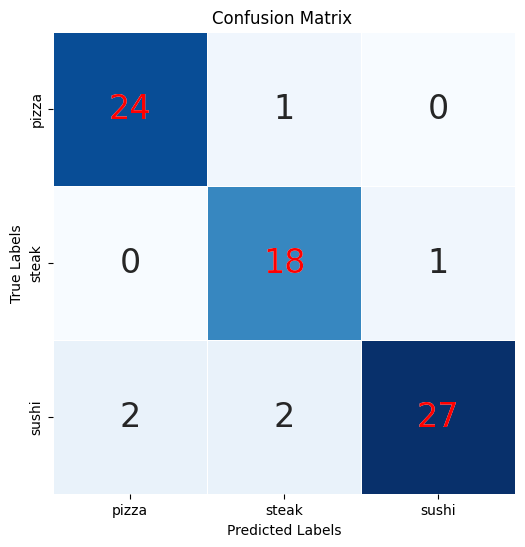

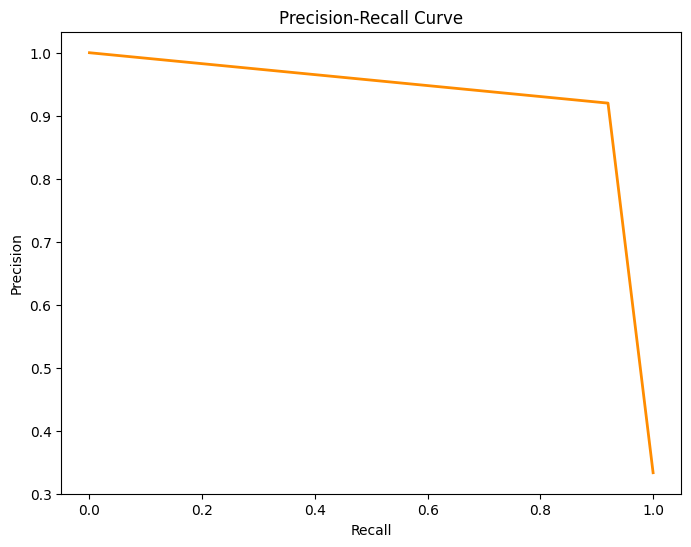

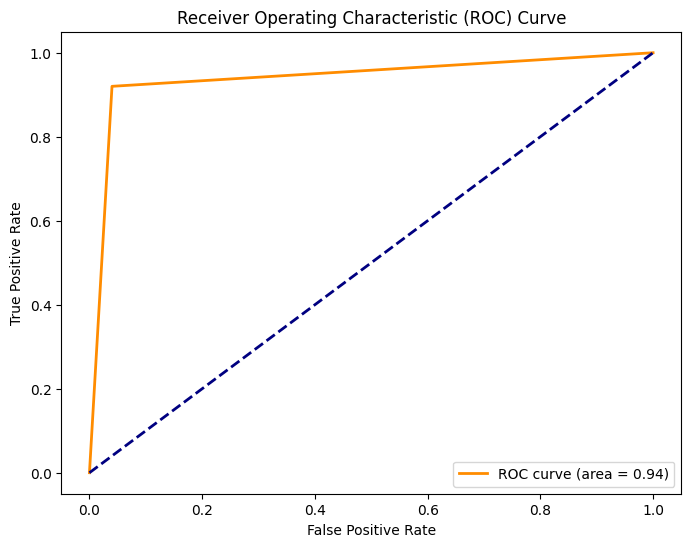

{'model_name': 'EfficientNet', 'model_loss': 0.23295818269252777, 'model_acc': 91.76136363636363, 'precision': 0.9148351648351648, 'recall': 0.9261120543293718, 'f1': 0.9188102359587903, 'confusion_matrix': array([[24,  1,  0],
       [ 0, 18,  1],
       [ 2,  2, 27]])}


In [24]:

import logging
import time
import torch
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, precision_recall_curve, roc_curve, auc
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader


def evaluate_model(model, data_loader, loss_fn, accuracy_fn, custom_labels):
    model = model.to("cuda")

    loss, acc = 0, 0
    all_true_labels, all_predicted_labels = [], []

    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X = X.to("cuda")
            y = y.to("cuda")
            y_pred = model(X)

            loss += loss_fn(y_pred, y).detach()
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

            all_true_labels.extend(y.cpu().numpy())
            all_predicted_labels.extend(y_pred.argmax(dim=1).cpu().numpy())

        loss /= len(data_loader)
        acc /= len(data_loader)

    precision, recall, f1, _ = precision_recall_fscore_support(
        all_true_labels, all_predicted_labels, average='macro', zero_division=0
    )

    conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

    y_true_onehot = label_binarize(all_true_labels, classes=np.unique(all_true_labels))
    y_pred_onehot = label_binarize(all_predicted_labels, classes=np.unique(all_true_labels))

    result = {
        "model_name": model.__class__.__name__,
        "model_loss": loss.item(),
        "model_acc": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": conf_matrix
    }

    plot_confusion_matrix(conf_matrix, custom_labels)
    plot_precision_recall_curve(y_true_onehot, y_pred_onehot)
    plot_roc_curve(y_true_onehot, y_pred_onehot)

    return result

def plot_confusion_matrix(conf_matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels,
                cbar=False, linewidths=.5, annot_kws={"size": 24}, square=True)

    for i in range(len(labels)):
        plt.text(i + 0.5, i + 0.5, f'{conf_matrix[i, i]}', ha='center', va='center', color='red', fontsize=24)

    plt.title('Confusion Matrix ')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

def plot_precision_recall_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true.ravel(), y_scores.ravel())

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='darkorange', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true.ravel(), y_scores.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


# Training
start = time.time()
results = train(model1, train_dataloader, test_dataloader, optimizer, loss_fn, accuracy_fn, epochs=100, early_stop_patience=10)
end = time.time()
time_taken = end - start
time_taken_in_minutes = int(time_taken / 60)
logging.info(f"Training time: {time_taken_in_minutes} minutes")

# Evaluation
evaluation_results = evaluate_model(model1, test_dataloader, loss_fn, accuracy_fn, custom_labels=class_names)
print(evaluation_results)

In [ ]:
import itertools
import torch
import time
import logging

# Define ranges for hyperparameters
learning_rates = [1e-3, 1e-4, 1e-5]
weight_decays = [1e-3, 1e-4, 1e-5]
optimizers = [torch.optim.Adam, torch.optim.SGD]
epochs_list = [50]
# Perform hyperparameter tuning
best_model = None
best_evaluation_results = None
best_hyperparameters = None
best_accuracy = 0.0

# Load EfficientNet-B7 with default (ImageNet) weights
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

# Define the get_state_dict function
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)

# Override the get_state_dict function in WeightsEnum
WeightsEnum.get_state_dict = get_state_dict

for lr, weight_decay, optimizer_class, epochs in itertools.product(learning_rates, weight_decays, optimizers, epochs_list):
    # Load EfficientNet-B7 with default (ImageNet) weights
    model1 = efficientnet_b7(weights=EfficientNet_B7_Weights.DEFAULT)

    # Freeze parameters in the feature extractor part
    for param in model1.features.parameters():
        param.requires_grad = False

    # Define custom classifier
    model1.classifier = nn.Sequential(
        nn.Dropout(0.3, inplace=True),
        nn.Linear(
            in_features=2560,  # Assuming the last layer of EfficientNet-B7 has 2560 output features
            out_features=len(class_names),
            bias=True
        )
    )

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model1.to(device)

    optimizer = optimizer_class(model1.parameters(), lr=lr, weight_decay=weight_decay)

    # Training
    start = time.time()
    results = train(model1, train_dataloader, test_dataloader, optimizer, loss_fn, accuracy_fn, epochs=epochs, early_stop_patience=3)
    end = time.time()
    time_taken = end - start
    time_taken_in_minutes = int(time_taken / 60)
    logging.info(f"Training time for lr={lr}, weight_decay={weight_decay}, optimizer={optimizer_class.__name__}, epochs={epochs}: {time_taken_in_minutes} minutes")

    # Evaluation
    evaluation_results = evaluate_model(model1, test_dataloader, loss_fn, accuracy_fn, custom_labels=class_names)

    # Track best model
    if evaluation_results['model_acc'] > best_accuracy:
        best_accuracy = evaluation_results['model_acc']
        best_model = model1
        best_evaluation_results = evaluation_results
        best_hyperparameters = {'lr': lr, 'weight_decay': weight_decay, 'optimizer': optimizer_class.__name__, 'epochs': epochs}

print("Best hyperparameters:", best_hyperparameters)
print("Best evaluation results:", best_evaluation_results)


In [25]:
from typing import Dict, List
import matplotlib.pyplot as plt

import torch
def plot_curves(results: Dict[str, List[torch.Tensor]]):
    loss = [item.detach().cpu().numpy() if isinstance(item, torch.Tensor) else item for item in results["train_loss"]]
    test_loss = [item.detach().cpu().numpy() if isinstance(item, torch.Tensor) else item for item in results["test_loss"]]
    acc = [item.detach().cpu().numpy() if isinstance(item, torch.Tensor) else item for item in results["train_acc"]]
    test_acc = [item.detach().cpu().numpy() if isinstance(item, torch.Tensor) else item for item in results["test_acc"]]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, label="train_accuracy")
    plt.plot(epochs, test_acc, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    plt.show()


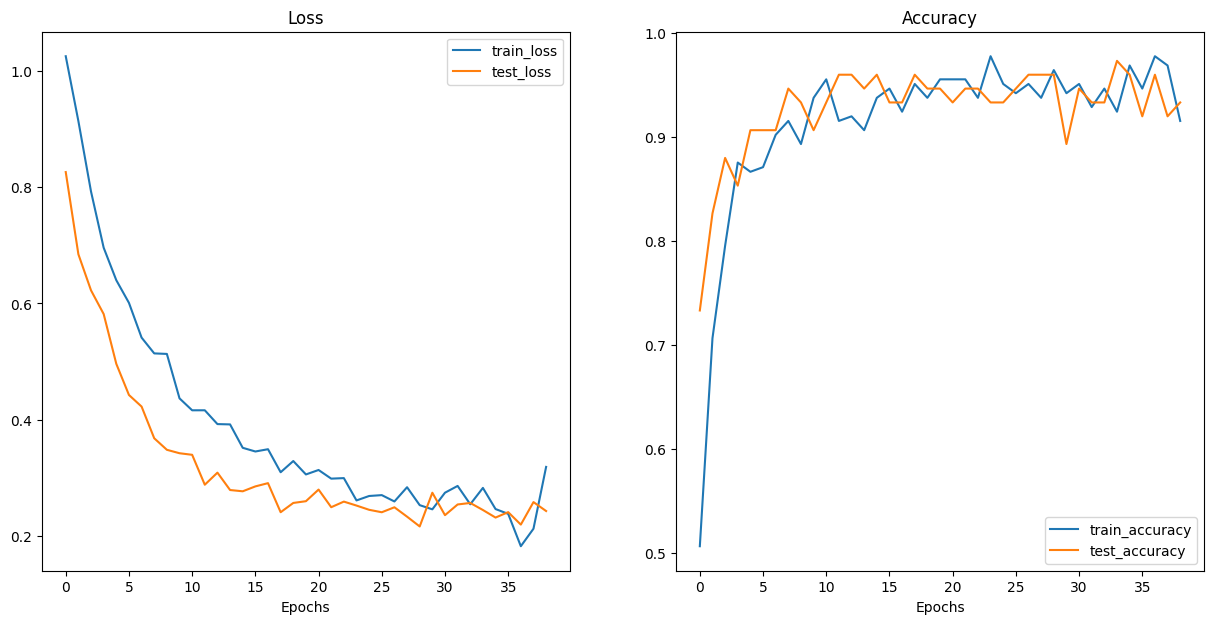

In [26]:
plot_curves(results)

In [27]:
import os
import torch

def save_model(model, target_dir, model_name):
    """
    Save a PyTorch model to a specified directory with a given name.

    Args:
        model (torch.nn.Module): The PyTorch model to be saved.
        target_dir (str): The directory where the model will be saved.
        model_name (str): The name of the model file.
    """
    # Ensure the target directory exists
    os.makedirs(target_dir, exist_ok=True)

    # Construct the path for saving the model
    model_path = os.path.join(target_dir, model_name)

    # Save the model state dictionary
    torch.save(model.state_dict(), model_path)

    print(f"Model saved successfully at: {model_path}")

In [28]:

# Save the model
save_model(model=model1,
                 target_dir="models",
                 model_name="effnetb7.pth")

Model saved successfully at: models/effnetb7.pth


In [29]:
effnetb7_total_params= sum(torch.numel(param) for param in model1.parameters())


In [30]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb7_model_size = Path("/content/models/effnetb7.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb7_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 244 MB


In [31]:
effnetb7_stats = {"test_loss": results["test_loss"][-1],
                  "test_acc": results["test_acc"][-1],
                  "number_of_parameters": effnetb7_total_params,
                  "model_size (MB)": pretrained_effnetb7_model_size}
effnetb7_stats

{'test_loss': 0.2432087888320287,
 'test_acc': tensor(0.9333, device='cuda:0', dtype=torch.float64),
 'number_of_parameters': 63794643,
 'model_size (MB)': 244}

In [93]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

In [94]:
# model = efficientnet_b7(weights="DEFAULT")
weights = torchvision.models.ViT_B_16_Weights.DEFAULT
weights


ViT_B_16_Weights.IMAGENET1K_V1

In [95]:
model2 = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)


In [96]:
model2

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [97]:
auto_transforms1 = transforms.Compose([
  transforms.TrivialAugmentWide(),
    # Previous transformations
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

auto_transforms1

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [98]:


train_dataloader1, test_dataloader1, class_names =  create_dataloaders(train_dir=train_dir,
                             test_dir=test_dir,
                             transform=auto_transforms1,
                             batch_size=32,
                             num_workers=2)

In [99]:
for param in model2.parameters():
  param.requires_grad = False


In [100]:
summary(model2, input_size =(1,3,224,224), col_names =["input_size","output_size","num_params","trainable"],
        row_settings = ["var_names"], col_width =20)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 1000]            768                  False
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 197

In [101]:
model2.heads= nn.Linear(in_features = 768,
                       out_features = 3)

In [102]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr =1e-3,
                             weight_decay = 1e-1
                            )


In [103]:
model2.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

  1%|          | 1/100 [00:04<07:50,  4.75s/it]

Epoch:1 | Train Loss:0.905 | Train Accuracy:0.596 | Test Loss: 0.520| Test accuracy:0.880


  2%|▏         | 2/100 [00:09<07:56,  4.86s/it]

Epoch:2 | Train Loss:0.471 | Train Accuracy:0.876 | Test Loss: 0.394| Test accuracy:0.893


  3%|▎         | 3/100 [00:14<07:48,  4.83s/it]

Epoch:3 | Train Loss:0.299 | Train Accuracy:0.942 | Test Loss: 0.323| Test accuracy:0.907


  4%|▍         | 4/100 [00:19<07:44,  4.84s/it]

Epoch:4 | Train Loss:0.268 | Train Accuracy:0.929 | Test Loss: 0.312| Test accuracy:0.880


  5%|▌         | 5/100 [00:24<07:52,  4.97s/it]

Epoch:5 | Train Loss:0.218 | Train Accuracy:0.951 | Test Loss: 0.242| Test accuracy:0.933


  6%|▌         | 6/100 [00:29<08:00,  5.11s/it]

Epoch:6 | Train Loss:0.201 | Train Accuracy:0.933 | Test Loss: 0.235| Test accuracy:0.933


  7%|▋         | 7/100 [00:34<07:52,  5.08s/it]

Epoch:7 | Train Loss:0.181 | Train Accuracy:0.951 | Test Loss: 0.234| Test accuracy:0.933


  8%|▊         | 8/100 [00:39<07:46,  5.07s/it]

Epoch:8 | Train Loss:0.188 | Train Accuracy:0.942 | Test Loss: 0.209| Test accuracy:0.893


  9%|▉         | 9/100 [00:45<07:48,  5.15s/it]

Epoch:9 | Train Loss:0.177 | Train Accuracy:0.951 | Test Loss: 0.229| Test accuracy:0.947


 10%|█         | 10/100 [00:50<07:39,  5.11s/it]

Epoch:10 | Train Loss:0.145 | Train Accuracy:0.969 | Test Loss: 0.241| Test accuracy:0.920


 11%|█         | 11/100 [00:55<07:30,  5.06s/it]

Epoch:11 | Train Loss:0.177 | Train Accuracy:0.938 | Test Loss: 0.215| Test accuracy:0.947


 12%|█▏        | 12/100 [01:00<07:26,  5.08s/it]

Epoch:12 | Train Loss:0.160 | Train Accuracy:0.960 | Test Loss: 0.241| Test accuracy:0.907


 13%|█▎        | 13/100 [01:05<07:14,  4.99s/it]

Epoch:13 | Train Loss:0.156 | Train Accuracy:0.960 | Test Loss: 0.246| Test accuracy:0.920


 14%|█▍        | 14/100 [01:10<07:12,  5.03s/it]

Epoch:14 | Train Loss:0.150 | Train Accuracy:0.947 | Test Loss: 0.240| Test accuracy:0.880


 15%|█▌        | 15/100 [01:15<07:01,  4.96s/it]

Epoch:15 | Train Loss:0.131 | Train Accuracy:0.964 | Test Loss: 0.220| Test accuracy:0.920


 16%|█▌        | 16/100 [01:19<06:50,  4.89s/it]

Epoch:16 | Train Loss:0.162 | Train Accuracy:0.960 | Test Loss: 0.243| Test accuracy:0.907


 17%|█▋        | 17/100 [01:24<06:46,  4.90s/it]

Epoch:17 | Train Loss:0.118 | Train Accuracy:0.973 | Test Loss: 0.248| Test accuracy:0.907


 17%|█▋        | 17/100 [01:30<07:19,  5.30s/it]

Epoch:18 | Train Loss:0.152 | Train Accuracy:0.942 | Test Loss: 0.214| Test accuracy:0.947
Early stopping at epoch 18 due to no improvement in test loss.


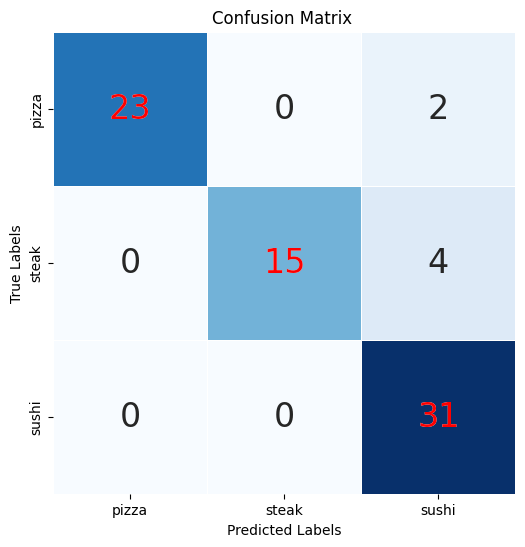

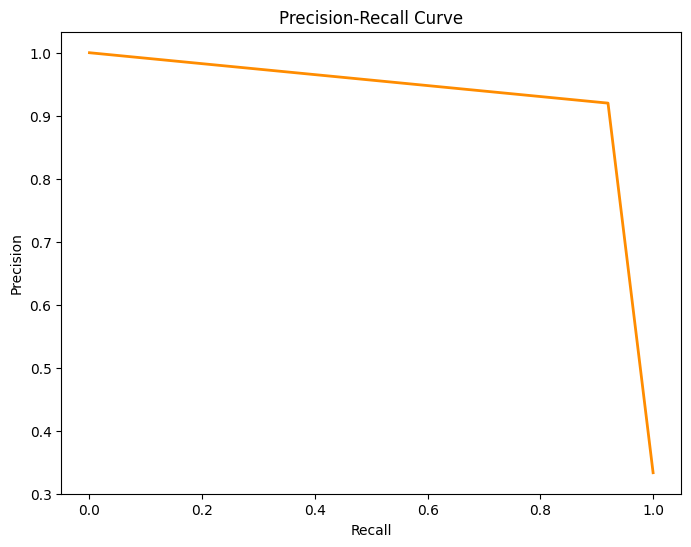

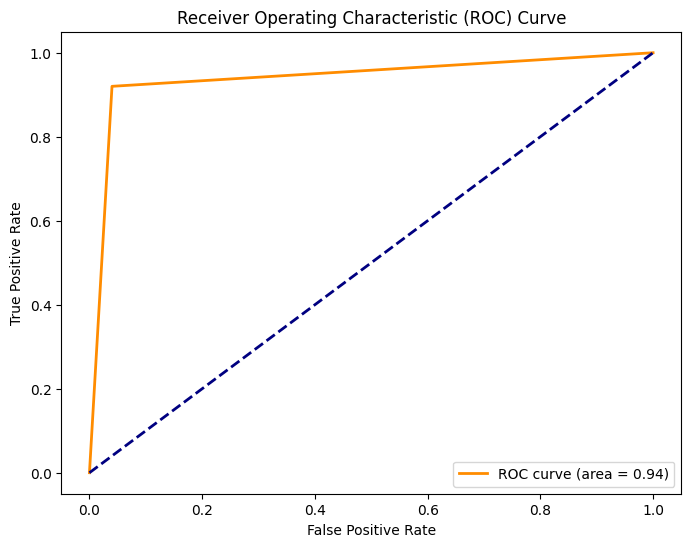

{'model_name': 'VisionTransformer', 'model_loss': 0.15805572271347046, 'model_acc': 93.75, 'precision': 0.9459459459459459, 'recall': 0.9031578947368422, 'f1': 0.9174836601307191, 'confusion_matrix': array([[23,  0,  2],
       [ 0, 15,  4],
       [ 0,  0, 31]])}


In [104]:

import logging
import time
import torch
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, precision_recall_curve, roc_curve, auc
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader


def evaluate_model(model, data_loader, loss_fn, accuracy_fn, custom_labels):
    model = model.to("cuda")

    loss, acc = 0, 0
    all_true_labels, all_predicted_labels = [], []

    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X = X.to("cuda")
            y = y.to("cuda")
            y_pred = model(X)

            loss += loss_fn(y_pred, y).detach()
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

            all_true_labels.extend(y.cpu().numpy())
            all_predicted_labels.extend(y_pred.argmax(dim=1).cpu().numpy())

        loss /= len(data_loader)
        acc /= len(data_loader)

    precision, recall, f1, _ = precision_recall_fscore_support(
        all_true_labels, all_predicted_labels, average='macro', zero_division=0
    )

    conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

    y_true_onehot = label_binarize(all_true_labels, classes=np.unique(all_true_labels))
    y_pred_onehot = label_binarize(all_predicted_labels, classes=np.unique(all_true_labels))

    result = {
        "model_name": model.__class__.__name__,
        "model_loss": loss.item(),
        "model_acc": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": conf_matrix
    }

    plot_confusion_matrix(conf_matrix, custom_labels)
    plot_precision_recall_curve(y_true_onehot, y_pred_onehot)
    plot_roc_curve(y_true_onehot, y_pred_onehot)

    return result

def plot_confusion_matrix(conf_matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels,
                cbar=False, linewidths=.5, annot_kws={"size": 24}, square=True)

    for i in range(len(labels)):
        plt.text(i + 0.5, i + 0.5, f'{conf_matrix[i, i]}', ha='center', va='center', color='red', fontsize=24)

    plt.title('Confusion Matrix ')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

def plot_precision_recall_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true.ravel(), y_scores.ravel())

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='darkorange', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true.ravel(), y_scores.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Assuming you have your dataset and DataLoader
# train_dataloader = DataLoader(...)
# test_dataloader = DataLoader(...)

# Your model, optimizer, loss_fn, and accuracy_fn
# vit = YourViTModel(...)
# optimizer = torch.optim.Adam(...)
# loss_fn = YourLossFunction(...)
# accuracy_fn = YourAccuracyFunction(...)

# Training
start = time.time()
results = train(model2, train_dataloader1, test_dataloader1, optimizer, loss_fn, accuracy_fn, epochs=100, early_stop_patience=10)
end = time.time()
time_taken = end - start
time_taken_in_minutes = int(time_taken / 60)
logging.info(f"Training time: {time_taken_in_minutes} minutes")

# Evaluation
evaluation_results = evaluate_model(model2, test_dataloader1, loss_fn, accuracy_fn, custom_labels=class_names)
print(evaluation_results)

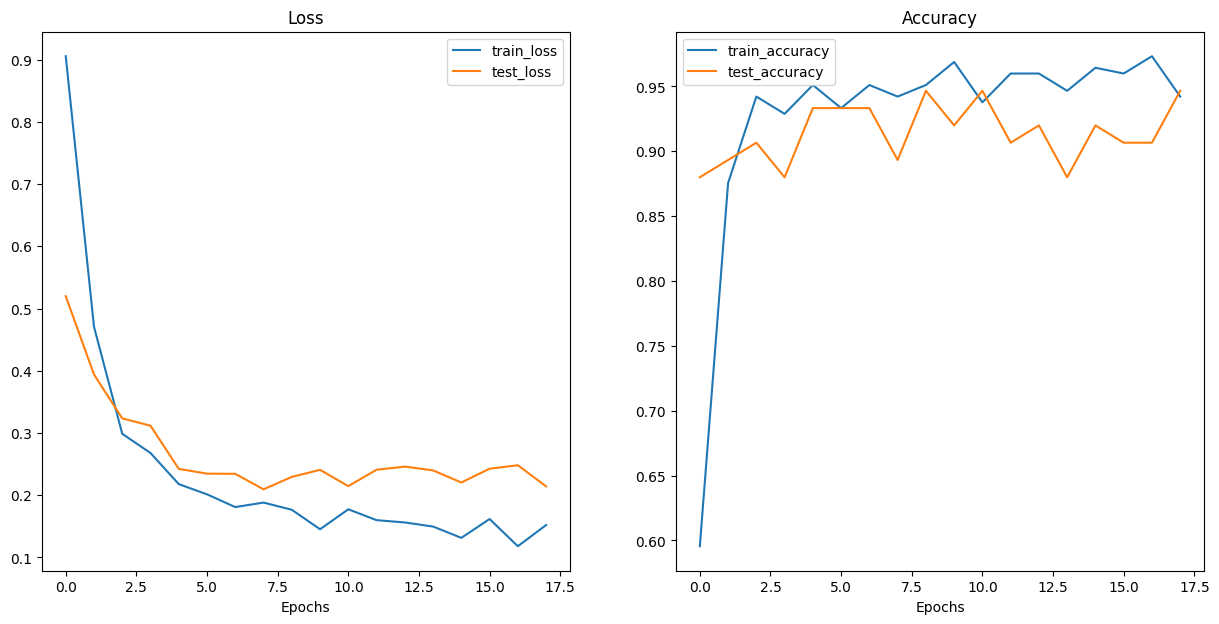

In [105]:
plot_curves(results)

In [106]:
# Save the model
save_model(model=model2,
                 target_dir="models",
                 model_name="VisionTransformer.pth")

Model saved successfully at: models/VisionTransformer.pth


In [107]:
VisionTransformer_total_params= sum(torch.numel(param) for param in model2.parameters())
VisionTransformer_total_params

85800963

In [108]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_VisionTransformer_model_size = Path("/content/models/VisionTransformer.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained VisionTransformer feature extractor model size: {pretrained_VisionTransformer_model_size} MB")

Pretrained VisionTransformer feature extractor model size: 327 MB


In [109]:
VisionTransformer_stats = {"test_loss": results["test_loss"][-1],
                  "test_acc": results["test_acc"][-1],
                  "number_of_parameters": VisionTransformer_total_params,
                  "model_size (MB)": pretrained_VisionTransformer_model_size}
VisionTransformer_stats

{'test_loss': 0.21425814112027486,
 'test_acc': tensor(0.9467, device='cuda:0', dtype=torch.float64),
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

In [110]:
effnetb7_stats

{'test_loss': 0.2432087888320287,
 'test_acc': tensor(0.9333, device='cuda:0', dtype=torch.float64),
 'number_of_parameters': 63794643,
 'model_size (MB)': 244}

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Results dictionary
results = {
    'effnetb7_stats': effnetb7_stats ,
    'VisionTransformer_stats': VisionTransformer_stats
}

# Convert results to DataFrame
df_results = pd.DataFrame(results).T

# Display the DataFrame
print("Results DataFrame:")
df_results


Results DataFrame:


,test_loss,test_acc,number_of_parameters,model_size (MB)
effnetb7_stats,0.243209,"tensor(0.9333, device='cuda:0', dtype=torch.fl...",63794643,244
VisionTransformer_stats,0.214258,"tensor(0.9467, device='cuda:0', dtype=torch.fl...",85800963,327


Selecting effnetb7 as the go to model

In [112]:
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data/pizza_steak_sushi/test


[PosixPath('data/pizza_steak_sushi/test/sushi/1434806.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2741434.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/719108.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2385731.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/887831.jpg')]

In [113]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

    # 2. Create an empty list to store prediction dictionaires
    pred_list = []

    # 3. Loop through target paths
    for path in tqdm(paths):

        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 6. Start the prediction timer
        start_time = timer()

        # 7. Open image path
        img = Image.open(path)

        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()

        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)

    # 15. Return list of prediction dictionaries
    return pred_list

In [114]:
# Make predictions across test dataset with EffNetB2
effnetb7_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=model1,
                                          transform=auto_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU

  0%|          | 0/75 [00:00<?, ?it/s]

In [115]:

# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb7_test_pred_df = pd.DataFrame(effnetb7_test_pred_dicts)
effnetb7_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi/test/sushi/1434806.jpg,sushi,0.9635,sushi,2.9327,True
1,data/pizza_steak_sushi/test/sushi/2741434.jpg,sushi,0.8580,sushi,2.1146,True
2,data/pizza_steak_sushi/test/sushi/719108.jpg,sushi,0.9472,sushi,2.1159,True
3,data/pizza_steak_sushi/test/sushi/2385731.jpg,sushi,0.9005,sushi,2.2198,True
4,data/pizza_steak_sushi/test/sushi/887831.jpg,sushi,0.9595,sushi,2.2485,True


In [116]:
effnetb7_test_pred_df.correct.value_counts()


True     71
False     4
Name: correct, dtype: int64

In [117]:
# Find the average time per prediction
effnetb7_average_time_per_pred = round(effnetb7_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB7 average time per prediction: {effnetb7_average_time_per_pred} seconds")

EffNetB7 average time per prediction: 2.3208 seconds


In [118]:
# Add EffNetB2 average prediction time to stats dictionary
effnetb7_stats["time_per_pred_cpu"] = effnetb7_average_time_per_pred
effnetb7_stats

{'test_loss': 0.2432087888320287,
 'test_acc': tensor(0.9333, device='cuda:0', dtype=torch.float64),
 'number_of_parameters': 63794643,
 'model_size (MB)': 244,
 'time_per_pred_cpu': 2.3208}

In [119]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=model2,
                                     transform=auto_transforms1,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/75 [00:00<?, ?it/s]

In [120]:
# Turn vit_test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi/test/sushi/1434806.jpg,sushi,0.9819,sushi,0.5631,True
1,data/pizza_steak_sushi/test/sushi/2741434.jpg,sushi,0.9959,sushi,0.4192,True
2,data/pizza_steak_sushi/test/sushi/719108.jpg,sushi,0.8319,sushi,0.4148,True
3,data/pizza_steak_sushi/test/sushi/2385731.jpg,sushi,0.9621,sushi,0.4159,True
4,data/pizza_steak_sushi/test/sushi/887831.jpg,sushi,0.9618,sushi,0.4121,True


In [121]:
vit_test_pred_df.correct.value_counts()


True     69
False     6
Name: correct, dtype: int64

In [122]:
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.4421 seconds


In [123]:
# Add average prediction time for ViT model on CPU
VisionTransformer_stats["time_per_pred_cpu"] = vit_average_time_per_pred
VisionTransformer_stats

{'test_loss': 0.21425814112027486,
 'test_acc': tensor(0.9467, device='cuda:0', dtype=torch.float64),
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.4421}

In [127]:
df = pd.DataFrame([effnetb7_stats, VisionTransformer_stats])

# Add column for model names
df["model"] = ["EffNetB7", "ViT"]

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.243209,"tensor(0.9333, device='cuda:0', dtype=torch.fl...",63794643,244,2.3208,EffNetB7
1,0.214258,"tensor(0.9467, device='cuda:0', dtype=torch.fl...",85800963,327,0.4421,ViT


/bin/bash: line 1: mdkir: command not found


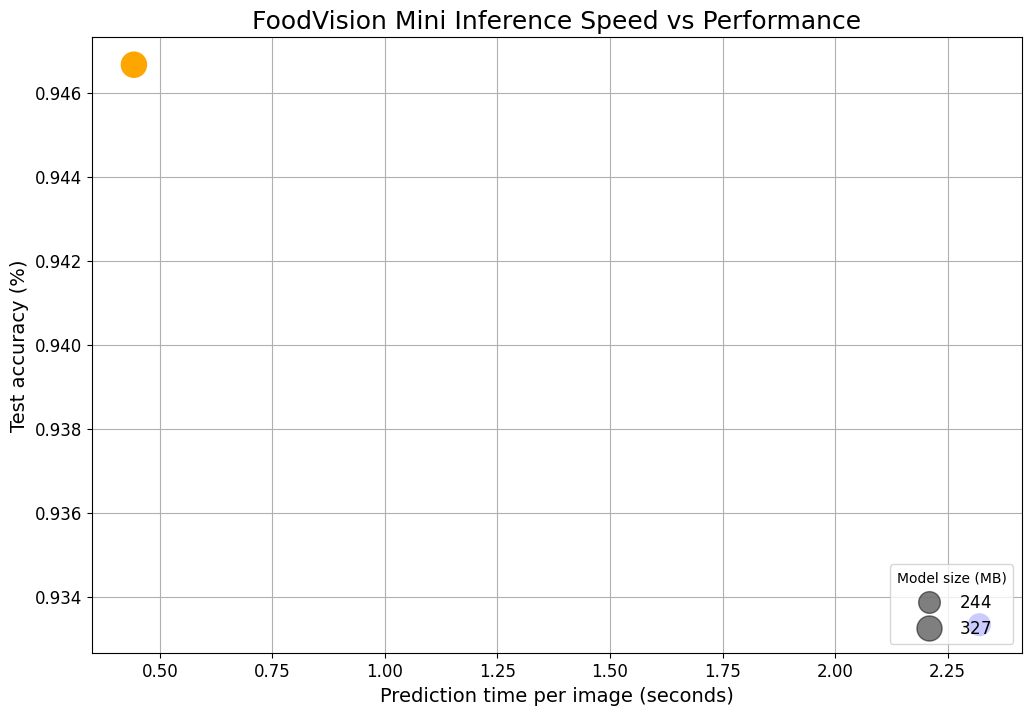

In [129]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
!mdkir images/

# Show the figure
plt.show()

In [130]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.8/306.8 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 97.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 11.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into accoun

In [131]:
# Put EffNetB2 on CPU
model2.to("cpu")

# Check the device
next(iter(model2.parameters())).device

device(type='cpu')

In [134]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = auto_transforms1(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    model2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(model2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

In [135]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data/pizza_steak_sushi/test/sushi/1680893.jpg

Prediction label and probability dictionary: 
{'pizza': 0.0019053240539506078, 'steak': 0.0010425872169435024, 'sushi': 0.9970520734786987}
Prediction time: 0.44575 seconds


In [137]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi/test/pizza/1503858.jpg'],
 ['data/pizza_steak_sushi/test/pizza/1925494.jpg'],
 ['data/pizza_steak_sushi/test/sushi/1987407.jpg']]

In [139]:
import gradio as gr

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An  feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://4581b49754f96acd18.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
